In [1]:
!pip install lexical-diversity nltk 
!pip install openai
!pip install xgboost


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd 
import nltk
nltk.download('punkt')
from lexical_diversity import lex_div as ld
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kimyingwong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def compute_lexical_measures(text):
    tokens = word_tokenize(text)  # More accurate than split()
    mattr_50 = ld.mattr(tokens, window_length=50)
    mtld = ld.mtld(tokens)
    ttr = ld.ttr(tokens)
    return pd.Series({
        'mattr_50': mattr_50,
        'mtld': mtld,
        'ttr': ttr
    })

In [4]:
train_df = pd.read_csv("./learning-agency-lab-automated-essay-scoring-2/train.csv")

In [5]:
lexical_features = train_df['full_text'].apply(compute_lexical_measures)
df_lex = pd.concat([train_df, lexical_features], axis=1)

In [6]:
df_lex.dropna(inplace=True)

In [7]:
df_lex

,essay_id,full_text,score,mattr_50,mtld,ttr
0,000d118,Many people have car where they live. The thin...,3,0.826210,86.951661,0.455046
1,000fe60,I am a scientist at NASA that is discussing th...,3,0.795963,71.472059,0.452830
2,001ab80,People always wish they had the same technolog...,4,0.821583,91.302984,0.401653
3,001bdc0,"We all heard about Venus, the planet without a...",4,0.815844,107.736209,0.471624
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,0.737453,55.620344,0.373206
...,...,...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,0.798136,65.573488,0.580838
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,0.818420,82.848435,0.406832
17304,fff016d,If you don't like sitting around all day than ...,2,0.770430,60.201235,0.485106
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,0.809302,88.000000,0.541667


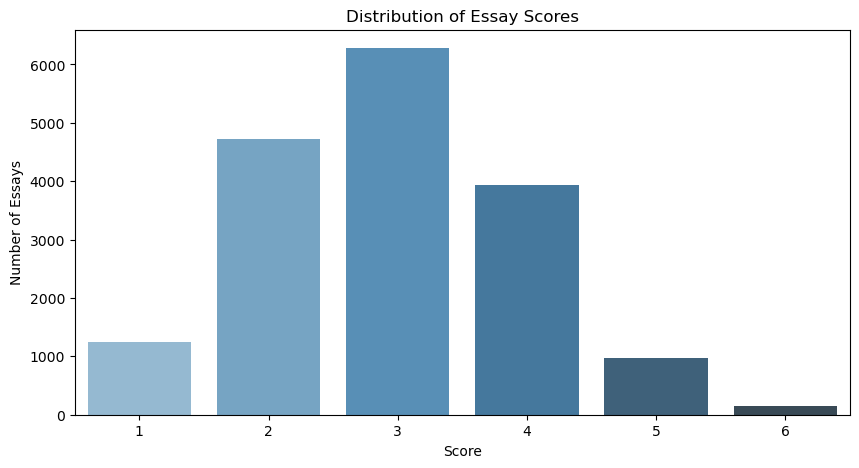

In [8]:
# VISUALIZE THE SCORE DISTRIBUTION
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=df_lex, x="score", palette="Blues_d")
plt.title("Distribution of Essay Scores")
plt.xlabel("Score")
plt.ylabel("Number of Essays")
plt.show()

In [15]:
# sampling for prediction 
# Include all rare scores
# Score 6: Keep all
rare_6 = df_lex[df_lex["score"] == 6].apply(
    lambda x: x.sample(frac=0.5, random_state=42)
)

# Score 1 & 5: Keep 50%
rare_1_5 = df_lex[df_lex["score"].isin([1, 5])].groupby("score", group_keys=False).apply(
    lambda x: x.sample(frac=0.05, random_state=42)
)

# Scores 2, 3, 4: Sample 15%
common = df_lex[df_lex["score"].isin([2, 3, 4])].groupby("score", group_keys=False).apply(
    lambda x: x.sample(frac=0.02, random_state=42)
)

# Combine all sampled subsets
selected_train_df = pd.concat([rare_6, rare_1_5, common]).reset_index(drop=True)



In [16]:
selected_train_df

,essay_id,full_text,score,mattr_50,mtld,ttr
0,a1cd4ce,Our country's history with cars date back a fe...,6,0.801251,83.266659,0.372070
1,77cb526,"The ""Facial Action Coding System"" or ""FACS"" is...",6,0.802470,80.503531,0.362033
2,86f807f,"In ""The Challeneges of Exploring Venus"", the a...",6,0.812300,80.192292,0.404070
3,7fe2d12,"To the state and the state's country, the elec...",6,0.792805,77.032939,0.313898
4,b8103da,"Dear Florida State Senator,\n\nEvery 4 years, ...",6,0.760657,60.622513,0.326992
...,...,...,...,...,...,...
483,5df9875,Cars are a basic need for people today we use ...,4,0.812504,93.676602,0.436391
484,4c28b83,"Every day people wake up, get ready, and go to...",4,0.826307,100.937270,0.475038
485,09da56a,Over the years the amount of cars that have be...,4,0.799532,82.566400,0.449587
486,95285d8,Their are people that think the fece on mars w...,4,0.749178,61.215140,0.439883


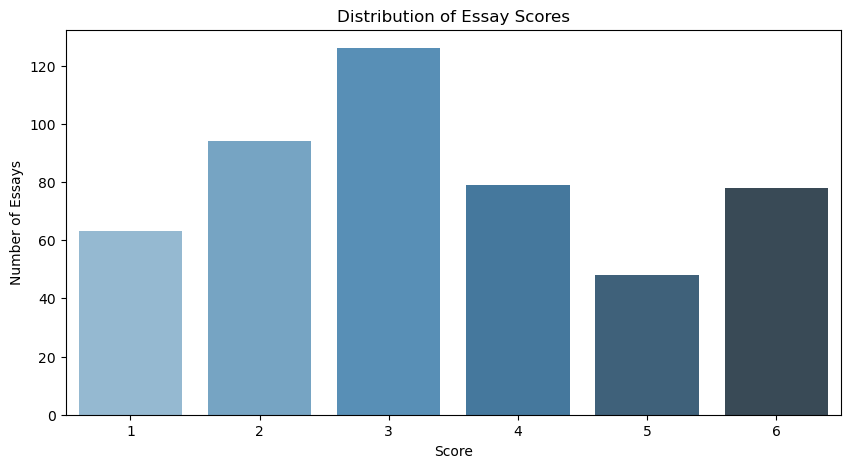

In [17]:
#plot selected train df
plt.figure(figsize=(10, 5))
sns.countplot(data=selected_train_df, x="score", palette="Blues_d")
plt.title("Distribution of Essay Scores")
plt.xlabel("Score")
plt.ylabel("Number of Essays")
plt.show()

In [25]:
import re
import os
from dotenv import load_dotenv
from openai import OpenAI

# Load your API key from .env
load_dotenv()
client = OpenAI()

rubric_text = """
Scale: 1 (lowest) to 6 (highest), with equal intervals between grades.

Score of 6:

Demonstrates clear and consistent mastery with minimal errors.
Effectively develops a clear, insightful point of view supported by appropriate, well-integrated evidence.
Well-organized, focused, and coherent with smooth idea progression.
Skillful language use with varied, accurate vocabulary and sentence structures.
Few or no grammatical or mechanical errors.

Score of 5:

Demonstrates reasonably consistent mastery with some occasional lapses.
Develops a strong, clear point of view supported by appropriate evidence.
Well-organized with logical flow of ideas.
Good language facility with appropriate vocabulary and variety, minor errors possible.

Score of 4:

Demonstrates adequate mastery with lapses in quality.
Develops a point of view with sufficient critical thinking, but may be inconsistent.
Generally organized and focused; coherence is present but not seamless.
Adequate language use; some vocabulary, grammatical or mechanical errors.

Score of 3:

Demonstrates developing mastery with notable weaknesses.
Point of view is inconsistent or supported by insufficient or inadequate evidence.
Limited organization, focus, and coherence; noticeable lapses.
Facility in language present, but with weak vocabulary or sentence structure issues, and some errors in grammar/mechanics.

Score of 2:

Demonstrates little mastery, with several flaws.
Vague or seriously limited point of view, weak critical thinking, poorly supported.
Poor organization and coherence; serious issues in idea progression.
Limited language facility, frequent errors that obscure meaning.

Score of 1:

Very little or no mastery.
No clear point of view or supporting evidence.
Disorganized, incoherent, and severely flawed in language and mechanics.
Pervasive errors severely interfere with understanding.
"""
def score_essay(essay_text: str) -> int:
    try:
        response = client.chat.completions.create(
            model="gpt-4.1-nano",
            messages=[
                {
                    "role": "system",
                    "content": f"""
You are an AI essay grader. Grade the following student essay from Grade 7 to 10 on a scale from 1 to 6, using the rubric below.
Evaluate the essay using the rubric and return only a number from 1 to 6. Do not include any explanation or words—just return the number.
Rubric:
{rubric_text}
"""
                },
                {
                    "role": "user",
                    "content": essay_text
                }
            ],
            temperature=0,
            max_tokens=100
        )
        result = response.choices[0].message.content.strip()
        print("result -->", result)
        
        # Use regex to extract only the number
        match = re.search(r'\b[1-6]\b', result)
        if match:
            return int(match.group())
        else:
            print(f"Unexpected format: '{result}'")
            return -1  # fallback score if parsing fails
    except Exception as e:
        print(f"Error: {e}")
        return -1  # fallback score if error


In [26]:
selected_train_df['predicted_score'] = selected_train_df['full_text'].apply(score_essay)


result --> 3
result --> 3
result --> 4
result --> 3
result --> 3
result --> 4
result --> 4
result --> 3
result --> 4
result --> 4
result --> 3
result --> 4
result --> 3
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 3
result --> 3
result --> 3
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 3
result --> 3
result --> 4
result --> 5
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 3
result --> 4
result --> 4
result --> 3
result --> 4
result --> 5
result --> 4
result --> 5
result --> 3
result --> 4
result --> 4
result --> 3
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 3
result --> 4
result --> 2
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 3
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4
result --> 4

In [29]:
selected_train_df['predicted_score'] 

0      3
1      3
2      4
3      3
4      3
      ..
483    3
484    3
485    4
486    2
487    3
Name: predicted_score, Length: 488, dtype: int64

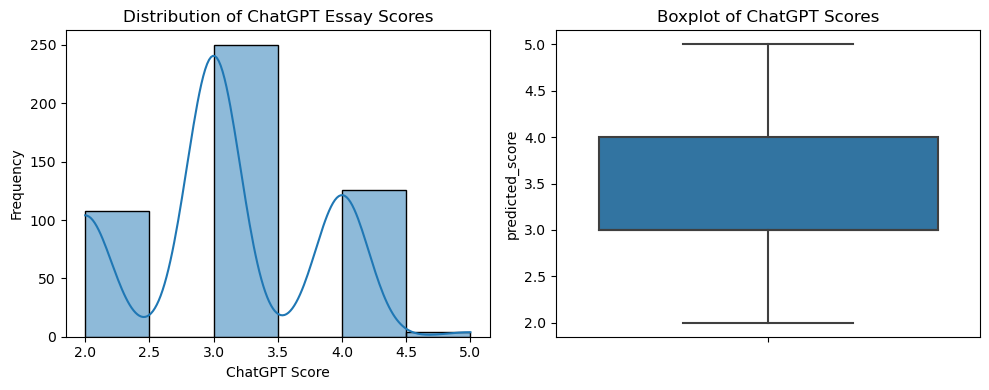

In [30]:

# Histogram of ChatGPT scores
plt.figure(figsize=(10, 4))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(selected_train_df['predicted_score'], bins=6, kde=True)
plt.title("Distribution of ChatGPT Essay Scores")
plt.xlabel("ChatGPT Score")
plt.ylabel("Frequency")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=selected_train_df['predicted_score'])
plt.title("Boxplot of ChatGPT Scores")

plt.tight_layout()
plt.show()


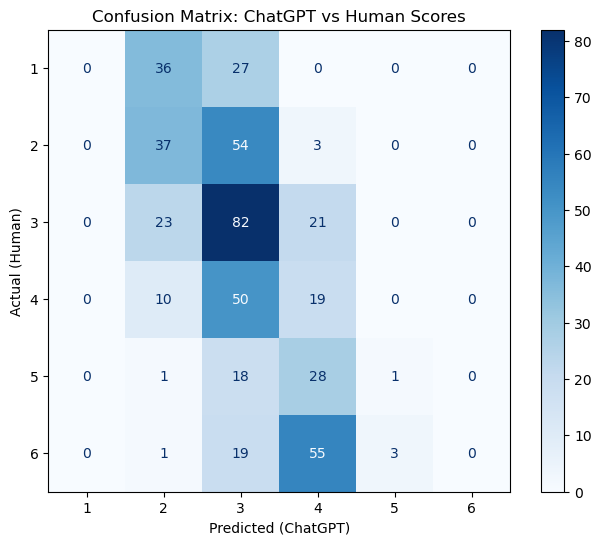

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make sure both columns are integers
selected_train_df["score"] = selected_train_df["score"].astype(int)
selected_train_df["predicted_score"] = selected_train_df["predicted_score"].astype(int)

# Compute confusion matrix
cm = confusion_matrix(selected_train_df["score"], selected_train_df["predicted_score"], labels=[1, 2, 3, 4, 5, 6])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5, 6])

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix: ChatGPT vs Human Scores")
plt.xlabel("Predicted (ChatGPT)")
plt.ylabel("Actual (Human)")
plt.show()


In [32]:
from sklearn.metrics import cohen_kappa_score

# Ensure both columns are integers
df_lex["score"] = selected_train_df["score"].astype(int)
df_lex["predicted_score"] = selected_train_df["predicted_score"].astype(int)

# Calculate QWK (Quadratic Weighted Kappa)
qwk = cohen_kappa_score(selected_train_df["score"], selected_train_df["predicted_score"], weights='quadratic')

# Output the QWK score
print("Quadratic Weighted Kappa (QWK):", qwk)


Quadratic Weighted Kappa (QWK): 0.44281624250506724


/Users/kimyingwong/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


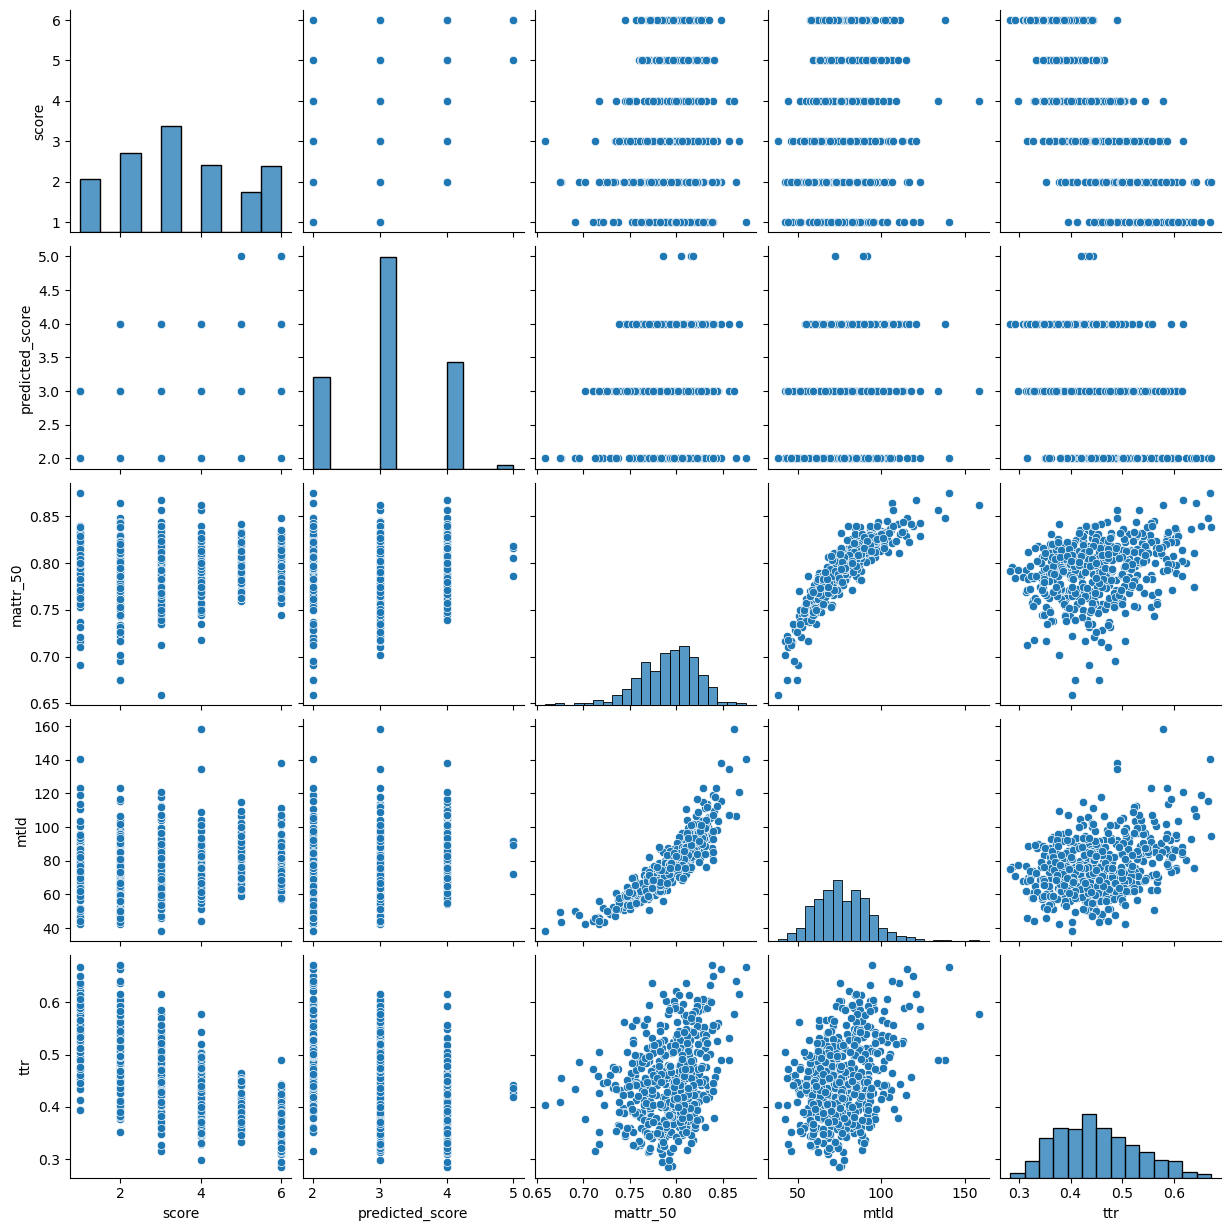

In [34]:
# pairplot for the label < == > predictors 

# Select columns for pairplot (adjust based on your data)
selected_columns = ['score', 'predicted_score', 'mattr_50', 'mtld', 'ttr']

# Create a pairplot
sns.pairplot(selected_train_df[selected_columns])

# Show the plot
plt.show()


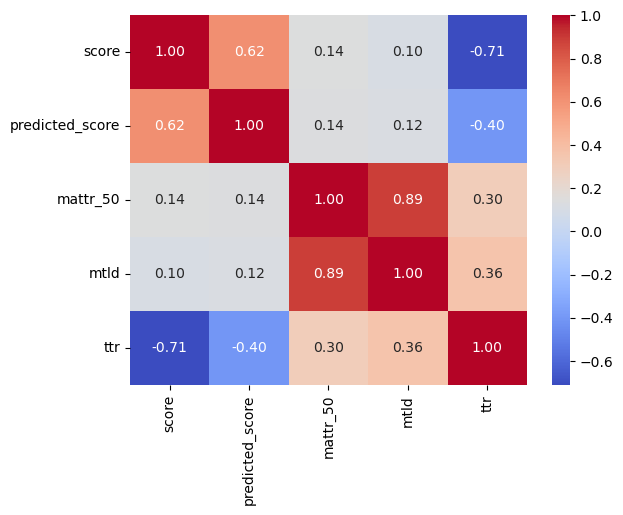

In [35]:

# Select columns for correlation heatmap (adjust based on your data)
selected_columns = ['score', 'predicted_score', 'mattr_50', 'mtld', 'ttr']

# Compute correlation matrix
corr = selected_train_df[selected_columns].corr()

# Create heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

# Display the plot
plt.show()


In [37]:
## seperate the training and test set
from sklearn.model_selection import train_test_split

# Split the data
train_df, test_df = train_test_split(selected_train_df, test_size=0.4, random_state=42)

# Check the sizes
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 292
Test set size: 196


In [38]:
from sklearn.ensemble import RandomForestClassifier
# Assuming train_df has the necessary features and 'score' as target
X_train = train_df[['predicted_score', 'mattr_50', 'mtld', 'ttr']]  # Example features
y_train = train_df['score']  # Human score as target

X_test = test_df[['predicted_score', 'mattr_50', 'mtld', 'ttr']]  # Example features

y_test = test_df['score']  # Human score as target

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')



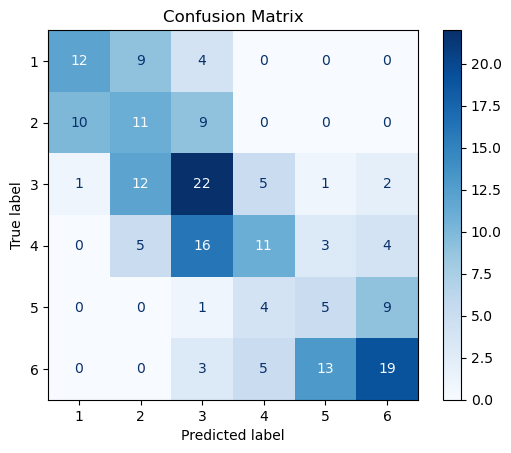

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5, 6])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5, 6])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [41]:
qwk

0.7910183255759606

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def qwk_scorer(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Wrap with make_scorer
qwk = make_scorer(qwk_scorer, greater_is_better=True)

clf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=clf,
                           param_grid=param_grid,
                           cv=5,
                           scoring= qwk,
                           n_jobs=-1,  # Use all cores
                           verbose=1)

# Fit to training data
grid_search.fit(X_train, y_train)

# View best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test data
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.7877413450172728


Test QWK: 0.8111


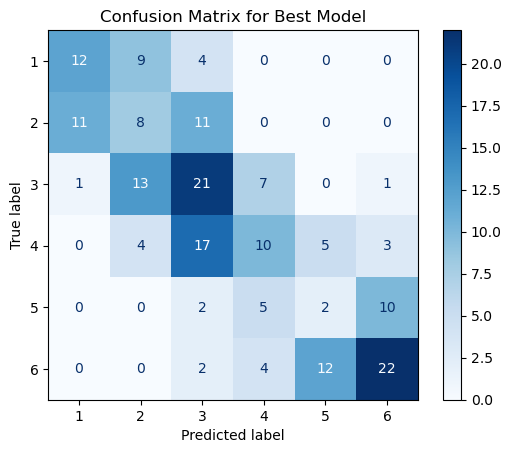

In [47]:
y_pred_test = best_model.predict(X_test)
test_qwk = cohen_kappa_score(y_test, y_pred_test, weights='quadratic')
print("Test QWK:", round(test_qwk, 4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test, labels=[1, 2, 3, 4, 5, 6])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5, 6])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Model")
plt.show()